In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm

In [2]:
# Generate example data
levels = 5
ntrials = 252

x = range(1,levels+1)
y = range(1,levels+1)
p1, p2 = np.meshgrid(x,y)
p1 = p1.reshape(-1)
p2 = p2.reshape(-1)
points = np.array([[a,d] for a,d in zip(p1,p2)])

# sample pairs
angles = []
distances = []
for n in range(ntrials):
    m1_index,m2_index = np.random.choice(points.shape[0],2,replace=False)
    m1,m2 = points[m1_index,:],points[m2_index,:]
    x_dis = m2[0] - m1[0]
    y_dis = m2[1] - m1[1]
    angle = np.rad2deg(np.arctan2(y_dis, x_dis)) # -pi : pi
    distance = np.sqrt(x_dis**2 + y_dis**2)
    angles.append(angle)
    distances.append(distance)

omegas = range(-29,30,5) # 根据Erie 的代码重新改范围
omega = np.random.choice(omegas)

In [ ]:
# generate simulation data
for amp in

import pea
y_true = []
for angle,distance in zip(angles,distances):
    noise = 15 * np.random.rand()
    y_true.append(1 + 1*np.cos(np.deg2rad(6*(angle - omega))) + 1*distance +noise)

In [5]:
# generate simulation data
y_true = []
for angle,distance in zip(angles,distances):
    noise = 15 * np.random.rand()
    y_true.append(1 + 1*np.cos(np.deg2rad(6*(angle - omega))) + 1*distance +noise)


# split data
y_train = y_true[:int(len(y_true)/2)]
y_test = y_true[int(len(y_true)/2):]

angles_train = angles[:int(len(y_true)/2)]
angles_test = angles[int(len(y_true)/2):]

distance_train = distances[:int(len(y_true)/2)]
distance_test = distances[int(len(y_true)/2):]

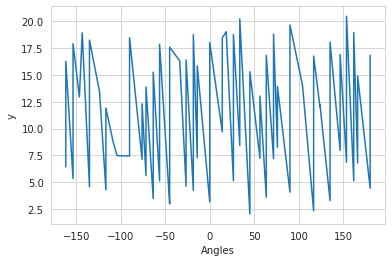

In [6]:
# plot the
import matplotlib.pyplot as plt

# sort the data by angles
angles_sorted, y_true_sorted = zip(*sorted(zip(angles, y_true)))
# create the plot
plt.plot(angles_sorted, y_true_sorted, '-')

# set the x-axis label
plt.xlabel('Angles')
# set the y-axis label
plt.ylabel('y')
# show the plot
plt.show()

In [7]:
# Create design matrix
x_sin = np.sin(np.deg2rad([6*a for a in angles_train]))
x_cos = np.cos(np.deg2rad([6*a for a in angles_train]))
data = pd.DataFrame({'y': y_train, 'distance': distance_train, 'cos': x_cos,'sin':x_sin})

# fit a GLM with distance and angle predictors
model = glm('y ~ distance + cos + sin', data=data).fit()
print(model.summary())

# test the hypothesis that both cosine and sine coefficients are zero
null_hypothesis = 'cos = 0, sin = 0'
f_test = model.f_test(null_hypothesis)
# print the F-test results
print(f_test.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  126
Model:                            GLM   Df Residuals:                      122
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          20.196
Method:                          IRLS   Log-Likelihood:                -366.10
Date:                Wed, 24 May 2023   Deviance:                       2463.9
Time:                        16:55:37   Pearson chi2:                 2.46e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1667      1.054      8.693      0.0

In [41]:
f_test.fvalue.reshape(-1)

1.1244399918535841

In [197]:
# Create design matrix
x_sin = np.sin(np.deg2rad([6*a for a in angles_train]))
x_cos = np.cos(np.deg2rad([6*a for a in angles_train]))
data = pd.DataFrame({'y': y_train, 'distance': distance_train, 'cos': x_cos,'sin':x_sin})

# fit a GLM with distance and angle predictors
model = glm('y ~ cos + sin', data=data).fit()
print(model.summary())

# test the hypothesis that both cosine and sine coefficients are zero
null_hypothesis = 'cos = 0, sin = 0'
f_test = model.f_test(null_hypothesis)
# print the F-test results
print(f_test.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  126
Model:                            GLM   Df Residuals:                      123
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          19.330
Method:                          IRLS   Log-Likelihood:                -363.85
Date:                Wed, 15 Feb 2023   Deviance:                       2377.6
Time:                        22:10:16   Pearson chi2:                 2.38e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9610      0.392     27.978      0.0

## Merge into a pipeline function

In [2]:

def simulation_pipeline(levels=5,ntrials=252,noiseAmp=1):
    # Generate example data
    x = range(1,levels+1)
    y = range(1,levels+1)
    p1, p2 = np.meshgrid(x,y)
    p1 = p1.reshape(-1)
    p2 = p2.reshape(-1)
    points = np.array([[a,d] for a,d in zip(p1,p2)])

    # sample pairs
    angles = []
    distances = []
    for n in range(ntrials):
        m1_index,m2_index = np.random.choice(points.shape[0],2,replace=False)
        m1,m2 = points[m1_index,:],points[m2_index,:]
        x_dis = m2[0] - m1[0]
        y_dis = m2[1] - m1[1]
        angle = np.rad2deg(np.arctan2(y_dis, x_dis)) # -pi : pi
        distance = np.sqrt(x_dis**2 + y_dis**2)
        angles.append(angle)
        distances.append(distance)

    omegas = range(-29,30,5) # 根据Erie 的代码重新改范围
    omega = np.random.choice(omegas)

    # generate simulation data
    y_true = []
    for angle,distance in zip(angles,distances):
        noise = noiseAmp * np.random.rand()
        y_true.append(1 + 1*np.cos(np.deg2rad(6*(angle - omega))) + 0.5*distance +noise)

    # Create data
    x_sin = np.sin(np.deg2rad([6*a for a in angles]))
    x_cos = np.cos(np.deg2rad([6*a for a in angles]))
    data = pd.DataFrame({'y': y_true, 'distance': distances, 'cos': x_cos,'sin':x_sin})

    # fit a GLM with distance and angle predictors
    model = glm('y ~ distance + cos + sin', data=data).fit()
    # test the hypothesis that both cosine and sine coefficients are zero
    null_hypothesis = 'cos = 0, sin = 0'
    f_test = model.f_test(null_hypothesis)
    f_full = f_test.fvalue

    # fit a GLM with angle predictors
    model = glm('y ~ cos + sin', data=data).fit()
    # test the hypothesis that both cosine and sine coefficients are zero
    null_hypothesis = 'cos = 0, sin = 0'
    f_test = model.f_test(null_hypothesis)
    f_angle = f_test.fvalue
    return f_full, f_angle


noise_list = []
f_full_list = []
f_angle_list = []

for noise in np.arange(1,10,0.1):
    print('noise:',noise)
    for i in range(20):
        f_full, f_angle = simulation_pipeline(5,252,noiseAmp=noise)
        noise_list.append(noise)
        f_full_list.append(float(f_full))
        f_angle_list.append(float(f_angle))

noise: 1.0
noise: 1.1
noise: 1.2000000000000002
noise: 1.3000000000000003
noise: 1.4000000000000004
noise: 1.5000000000000004
noise: 1.6000000000000005
noise: 1.7000000000000006
noise: 1.8000000000000007


KeyboardInterrupt: 

<AxesSubplot: >

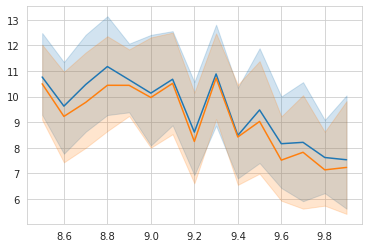

In [53]:
import seaborn as sns
sns.lineplot(x=noise_list[1500:],y=f_full_list[1500:])
sns.lineplot(x=noise_list[1500:],y=f_angle_list[1500:])

<AxesSubplot: >

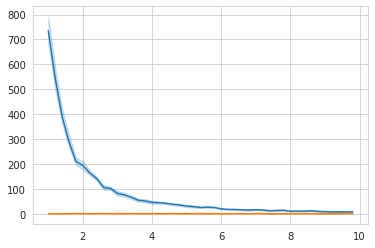

In [49]:
sns.lineplot(x=noise_list, y=f_full_list)
sns.lineplot(x=noise_list, y=f_angle_list)

In [16]:
import pandas as pd
import statsmodels.api as sm
from random import choices
import numpy as np


alignxdistance = np.concatenate([np.zeros(100),choices([1,2,3,4,5], k=100)])
misalignxdistance = np.concatenate([choices([1,2,3,4,5], k=100),np.zeros(100)])

align_constant = np.concatenate([np.ones(100),np.zeros(100)])
misalign_constant = np.concatenate([np.zeros(100),np.ones(100)])

#X = pd.DataFrame({'alignxdistance': alignxdistance, 'misalignxdistance': misalignxdistance})
#X = sm.add_constant(X)
X = pd.DataFrame({'align_constant':align_constant,'misalign_constant':misalign_constant,
                  'alignxdistance': alignxdistance, 'misalignxdistance': misalignxdistance})

# There is no any actaul distance effect. The data is randomly generated. The only rule is align bigger than misalign.
Y = np.concatenate([np.random.random(100)+10, np.random.random(100)])

model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.199e+04
Date:                Sun, 02 Jul 2023   Prob (F-statistic):          1.89e-247
Time:                        21:38:11   Log-Likelihood:                -22.752
No. Observations:                 200   AIC:                             53.50
Df Residuals:                     196   BIC:                             66.70
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
align_constant       10.4873      0.06

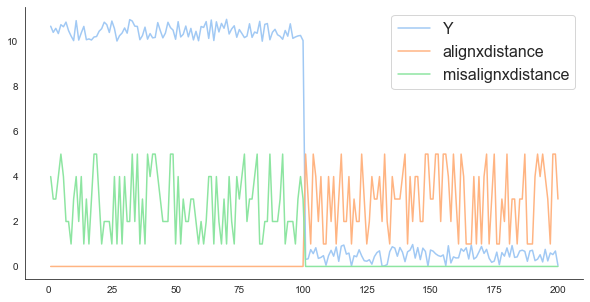

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

fig,ax = plt.subplots(figsize=(10,5))
sns.set_palette('pastelr')

sns.lineplot(x=range(1,201),y=Y,label='Y')
sns.lineplot(x=range(1,201),y=alignxdistance,label='alignxdistance')
sns.lineplot(x=range(1,201),y=misalignxdistance,label='misalignxdistance')
plt.legend(fontsize=16)